<a href="https://colab.research.google.com/github/d0lev/API-Security-Detection/blob/main/challenge_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cisco - Ariel University API Security Detection Challenge 2023
### Imports and global settings

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk import flatten
from urllib.parse import urlparse

In [5]:
# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_path = "/content/drive/MyDrive/CiscoChallenge/Data/dataset_2_train.json";
test_type = 'label' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(dataset_path) as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# **Preprocessing**

---
At this step we will engineer the various features in the data set,  It involves transforming data to forms that better relate to the underlying target to be learned. 
In the data set, there are various attacks on the API, for this purpose, we will create a binary column that will describe whether or not any attack was carried out in each record

In [6]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

for column in df.columns[df.isna().any()].tolist():
    df[column] = df[column].fillna('None')

# Any entry that contains a particular attack will be labeled malware.
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign': 
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

In [36]:
df.head(1)

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=w6oM9XV_jvWjuuVd3hLe3eSdXXPydbyfsLwTlj4Mc...,"Fri, 11 Nov 2022 03:12:09 GMT",GET,http://127.0.0.1:5000/static/download_txt/7115,,404 NOT FOUND,application/json,32,404,"{""error"": ""File not found""}",None,None,None,None,Benign,Benign


### **Dataset Description :**

---
Since the following data set is identical in its components compared to the first data set, the explanation of the data set can be found here: [notebook](https://github.com/d0lev/API-Security-Detection/blob/main/challenge_1.ipynb)

### **Classes distribution :**

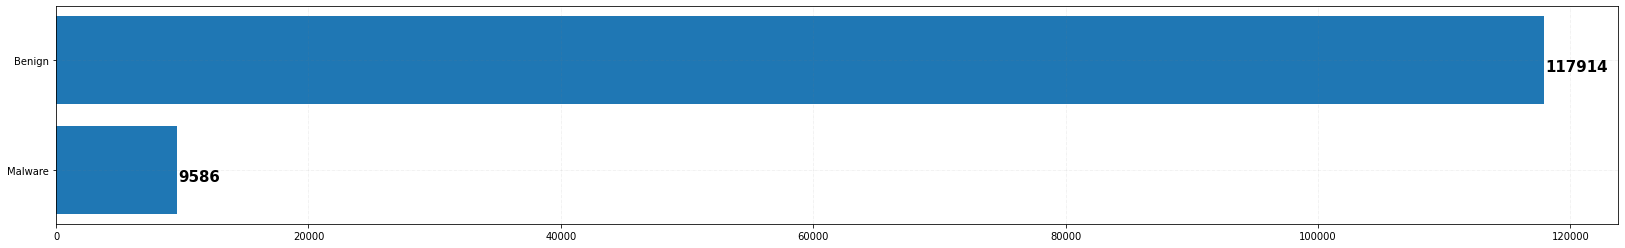

In [8]:
classes_distribution = df['label'].value_counts().to_frame().reset_index().to_numpy()

features = [classes_distribution[0][0],classes_distribution[1][0]]
values = [classes_distribution[0][1] , classes_distribution[1][1]]

fig, ax = plt.subplots(figsize =(28, 4)) 
# Horizontal Bar Plot
ax.barh(features, values)
# Add x, y gridlines
ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.2)
# Show top values
ax.invert_yaxis()
# Add annotation to bars
counter = 0
for i in ax.patches:
    plt.text(i.get_width() + 100, i.get_y() + 0.5, str(round((i.get_width()), 2)),fontsize = 15, fontweight ='bold', color ='black')

# Show Plot
plt.show()


As you can see, the data set is not balanced at all, and therefore we will have to use methods that handle this problem.

In [9]:
df.shape

(127500, 26)

### **Feature Enginering :**


In [10]:
# Iterate through the data set and check for each column what types it contains and their quantities.
def non_unique_features(dataframe):
  features , unique_values = ([],[])
  same_value_features = []
  for (col_name,col_value) in dataframe.iteritems():
      if (col_name != "label" and col_name != "attack_type"):
          features.append(col_name)
          unique_values.append(len(np.unique(col_value)))
          if(unique_values[-1] == 1):
            # add the columns that contains one value for each record in the dataset
            same_value_features.append(col_name)

  return same_value_features

In [11]:
dataset = df.drop(non_unique_features(df), axis = 1)
dataset.head(2)

,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",de-CH,none,same-origin,document,['ck=w6oM9XV_jvWjuuVd3hLe3eSdXXPydbyfsLwTlj4Mc...,"Fri, 11 Nov 2022 03:12:09 GMT",GET,http://127.0.0.1:5000/static/download_txt/7115,404 NOT FOUND,application/json,32,404,"{""error"": ""File not found""}",None,None,None,None,Benign,Benign
1,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br","en-US,en;q=0.9,he;q=0.8",none,same-origin,document,['ck=c8uOUXcCTGAn3VPZ7KkmjeGl7T4m7z5hvteH_e4NP...,"Fri, 11 Nov 2022 03:01:18 GMT",GET,http://127.0.0.1:5000/about/random_page,200 OK,text/html; charset=utf-8,1163,200,"<figure><img src=""https://img-c.udemycdn.com/r...",None,None,None,None,Benign,Benign


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tf_idf_user_agent(dataframe):
    dataframe.reset_index(drop=True, inplace=True)
    v = TfidfVectorizer()
    x = v.fit_transform(dataframe['request.headers.User-Agent'])
    df1 = pd.DataFrame(x.toarray(), columns=v.get_feature_names())
    df1.reset_index(drop=True, inplace=True)
    dataframe.drop('request.headers.User-Agent',axis=1, inplace=True)
    dataframe = pd.concat([df1 , dataframe], axis=1)

    return dataframe

In [13]:
def cookie_parsing(dataframe):
  cookies = dataframe['request.headers.Cookie'].tolist()
  columns = ['user1','user2',"n_users"]
  cookie_dataset = []

  for cookie in cookies:
    if cookie == "None":
      cookie_dataset.append([0,0,0])
    else:
      cookie = cookie.replace("username=","")
      cookie_p = cookie.split(";")
      if len(cookie_p) == 2:
        cookie_p.append(2)
        cookie_dataset.append(cookie_p)
      else:
        cookie_p.append(0)
        cookie_p.append(1)
        cookie_dataset.append(cookie_p)

  cookie_dataset = pd.DataFrame(cookie_dataset, columns = columns,dtype = str) 
  cookie_dataset['n_users'] = pd.to_numeric(cookie_dataset['n_users'])

  return cookie_dataset

In [14]:
def url_parsing(dataframe):
  urls = dataframe['request.url'].tolist()
  columns = ["scheme","netloc","path","params","query","fragment"]
  url_dataset = []

  for url in urls:
    parsed_url = []
    url_p = urlparse(url)
    for index in range(len(url_p)):
        parsed_url.append(url_p[index])
    
    flattened_list = flatten(parsed_url)
    url_dataset.append(flattened_list)

  url_dataset = pd.DataFrame(url_dataset, columns = columns,dtype = str) 
  url_dataset.drop(['params','fragment'],axis = 1,inplace = True)

  return url_dataset

In [15]:
def dataset_arrange(dataframe , embeddings ,index):
  first_n_column  = dataframe.iloc[: , : index]
  second_n_column = dataframe.iloc[: ,index + 1:]
  first_n_column = first_n_column.join(embeddings)
  dataframe = first_n_column.join(second_n_column)

  return dataframe

The `response.headers.Content-Length` feature contains multiple string that represents the length of the content that send from the host, therfore we will convert them to numeric values.

In [16]:
def content_length_numeric(dataframe):
  columns = ['response.headers.Content-Length','response.status_code']
  for col_name in columns:
      dataframe[col_name] = pd.to_numeric(dataframe[col_name])
  return dataframe

There are some features that contain in their content two different types of information, one with a URL address and the other without. We will try to turn these columns into numeric values by setting 1 for a record that contains a URL in the same feature, and 0 otherwise.

In [17]:
def contain_url(dataframe):
  columns = ['request.headers.Accept-Encoding','request.headers.Sec-Fetch-Dest','request.headers.Sec-Fetch-Site']


  for col_name in columns:
      dataframe[col_name] = np.where(dataframe[col_name].str.contains("jndi"), 1, 0)

  return dataframe

### **Dealing with missing values :**


In [18]:
means = dataset.isnull().mean()
percentages = means[means > 0].round(4).mul(100).sort_values(ascending=False)
percentages

Series([], dtype: float64)

### **Dealing with categorical features**

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import xgboost as xgb

In [20]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer

# On these headers we will run a "simple" BOW
SIMPLE_HEADERS = [
                'request.method',
                'request.headers.Accept-Language',
                'response.headers.Content-Type',
                'request.headers.Sec-Fetch-Site',
                'n_users',
                'request.headers.Sec-Fetch-Mode',
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = ['request.headers.User-Agent',
                    'user1','user2','scheme','netloc','path','query',
                    'response.headers.Location',
                    'request.headers.Set-Cookie',
                    'response.body',
                    'request.headers.Content-Length',
                    'response.headers.Set-Cookie'
                    ]

COLUMNS_TO_REMOVE = ['request.headers.Date','response.status']

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    cookies = cookie_parsing(df)
    urls = url_parsing(df)
    df = dataset_arrange(df , cookies ,df.columns.get_loc("request.headers.Cookie"))
    df = dataset_arrange(df , urls ,df.columns.get_loc("request.url"))
    df = contain_url(df) ## create a column that represent indicator for url in the accept encoding
    df = content_length_numeric(df)
    # df = one_hot_content_type(df)

    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=2)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

In [21]:
dataset = vectorize_df(dataset)

In [22]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

def feature_selection (dataframe):

  X = dataframe.drop(['label','attack_type'],axis=1)
  columns = X.columns
  X = np.nan_to_num(X)
  y = dataframe['label']
  X = (X-X.min())/(X.max()-X.min())

  # k tells k top features to be selected
  # Score function Chi2 tells the feature to be selected using Chi Square
  test = SelectKBest(score_func=chi2, k = 18)
  fit = test.fit(X, y)

  delete_features = pd.DataFrame({'columns': columns, 'Kept': test.get_support()})
  delete_features = delete_features[(delete_features['Kept'] == False)]['columns'].to_list()

  return delete_features

In [23]:
delete_features = feature_selection(dataset)
dataset = dataset.drop(delete_features ,axis = 1)

In [24]:
dataset['label'] = df['label']
dataset['label'] = dataset['label'].map({'Benign': 0, 'Malware': 1})

In [25]:
dataset['label'].value_counts()

0    117914
1      9586
Name: label, dtype: int64

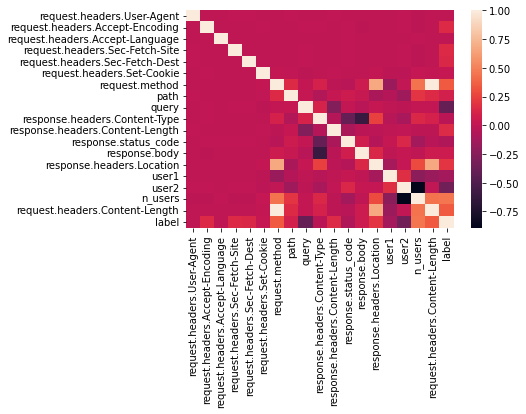

In [26]:
sns.heatmap(dataset.corr())

In [ ]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
dataset.info(memory_usage="deep")

In [ ]:
features_list = dataset.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')

print(features_list)
print(len(features_list))
# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
dataset.dtypes

### **Dealing with imbalanced dataset**

---



> ### 3. **Ensemble methods :**

In [29]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV

# Load the data
X = dataset[features_list]
y = dataset['label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Use undersampling to balance the training data
smote = SMOTE(random_state=42)
X_train_smoted, y_train_smoted = smote.fit_resample(X_train, y_train)

# Create the base models
model_1 = RandomForestClassifier(random_state=42)
model_2 = GradientBoostingClassifier(random_state=42)
model_3 = SVC(random_state=42)

In [ ]:
# # Define the hyperparameter grid
# param_grid = {
#     'learning_rate': [0.1, 0.2, 0.3],
#     'max_depth': [3, 4, 5],
#     'subsample': [0.5, 0.6, 0.7]
# }

# # Set up the GridSearchCV object
# grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# # Fit the model to the training data
# grid_search.fit(X_train_smoted, y_train_smoted)

# # Print the best hyperparameter values
# print('Best learning rate:', grid_search.best_params_['learning_rate'])
# print('Best maximum depth:', grid_search.best_params_['max_depth'])
# print('Best subsample rate:', grid_search.best_params_['subsample'])

In [30]:
clf = xgb.XGBClassifier(learning_rate = 0.2,max_depth = 5,subsample = 0.6,reg_lambda=1.5, reg_alpha=0.5)
clf.fit(X_train_smoted, y_train_smoted)

# We print our results
sns.set(rc={'figure.figsize':(15,8)})
predictions = clf.predict(X_test)
true_labels = y_test
clf_report = classification_report(true_labels, predictions, digits=5)

print(clf_report)

              precision    recall  f1-score   support

           0    0.99462   0.98896   0.99178     11780
           1    0.87464   0.93505   0.90384       970

    accuracy                        0.98486     12750
   macro avg    0.93463   0.96201   0.94781     12750
weighted avg    0.98549   0.98486   0.98509     12750



In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Use oversampling to balance the training data
oversampler = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

# Create the base models
model_1 = RandomForestClassifier(random_state=42)
model_2 = GradientBoostingClassifier(random_state=42)
model_3 = SVC(random_state=42)

# Create the boosting ensemble model
clf = xgb.XGBClassifier(base_estimator=[model_1, model_2, model_3] , learning_rate = 0.3,max_depth = 5,subsample = 0.6,reg_lambda=1, reg_alpha=0.5)

# Fit the model on the oversampled training data
clf.fit(X_train_oversampled, y_train_oversampled)

# We print our results
sns.set(rc={'figure.figsize':(15,8)})
predictions = clf.predict(X_test)
true_labels = y_test
clf_report = classification_report(true_labels, predictions, digits=5)

print(clf_report)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Load the data
X = dataset[features_list]
y = dataset['label']

undersampler = RandomUnderSampler(random_state=42)
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Use undersampling to balance the training data
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

model_1 = RandomForestClassifier(random_state=42)
model_2 = GradientBoostingClassifier(random_state=42)
model_3 = SVC(random_state=42)

# Create the boosting ensemble model
clf = xgb.XGBClassifier(base_estimator=[model_1, model_2, model_3] , learning_rate = 0.3,max_depth = 5,subsample = 0.6,reg_lambda=1, reg_alpha=0.5)
clf.fit(X_train_undersampled, y_train_undersampled)


# We print our results
sns.set(rc={'figure.figsize':(15,8)})
predictions = clf.predict(X_test)
true_labels = y_test
clf_report = classification_report(true_labels, predictions, digits=5)
print(clf_report)

# Test

In [31]:
with open("/content/drive/MyDrive/CiscoChallenge/Data/dataset_2_val.json") as file:
    raw_ds = json.load(file)

test_df = pd.json_normalize(raw_ds, max_level=2)

for column in test_df.columns[test_df.isna().any()].tolist():
    test_df[column] = test_df[column].fillna('None')

test_df = test_df.drop(non_unique_features(df), axis = 1)
test_df = vectorize_df(test_df)
# test_df = test_df.drop(delete_features,axis = 1)

In [32]:
X = test_df[features_list]
predictions = clf.predict(X)

In [33]:
malware = 0
benign = 0
for p in predictions:
  if p == 1:
     malware = malware + 1
  else:
     benign = benign + 1

In [35]:
print(malware)
print(benign)

1852
20648


# Save your predictions

In [ ]:
# Save your preditions
enc = LabelEncoder()
np.savetxt(f'/content/drive/MyDrive/CiscoChallenge/dataset_2_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')